## Spark Kubernetes cluster

Après une petite session découverte de l'environnement d'execution local en introduction puis avec l'api S3, nous allons découvrir l'environnement d'execution **kubernetes**.

Le schéma traditionnel pour comprendre l'architecture est le suivant :

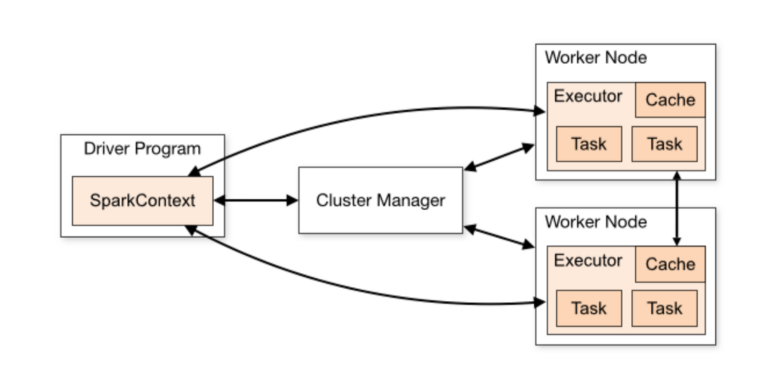

Nous allons comme auparavant créer un SparkContext sur un notebook python qui lance une JVM localement.
Ensuite ce programme driver se connectera à un Cluster Manager de type Kubernetes pour pouvoir lancer des workers.


#### Spark-shell versus Spark-submit (mode client et mode cluster)

Il est important, maintenant qu'on commence à manipuler des clusters spark, de rentrer dans ces détails d'architecture pour bien comprendre ce que l'on fait. 

Dans un **notebook jupyter nous faisons du spark shell** , à savoir que le datascientist peut intérargir avec son cluster spark en direct. C'est très séduisant mais néanmoins il ne faut pas oublier que pendant qu'on developpe et réfléchit à nos prochaines manipulations, notre application spark tourne déjà et reserve les ressources auprès du cluster. Il est donc recommandé de développer en intéractif avec moins de ressources et de plus petits jeux de données. 

A l'inverse, il est possible d'executer des **batchs spark**. Le programme s'arretant dès qu'il a fini son travail, il n'y a pas de gachis de ressources du à l'interaction et l'attente des commandes du datascientist.

Ces batchs sont executés via la commande **spark-submit** dont j'affiche l'aide ci-dessous


In [1]:
! /opt/spark/bin/spark-submit --help

Usage: spark-submit [options] <app jar | python file | R file> [app arguments]
Usage: spark-submit --kill [submission ID] --master [spark://...]
Usage: spark-submit --status [submission ID] --master [spark://...]
Usage: spark-submit run-example [options] example-class [example args]

Options:
  --master MASTER_URL         spark://host:port, mesos://host:port, yarn,
                              k8s://https://host:port, or local (Default: local[*]).
  --deploy-mode DEPLOY_MODE   Whether to launch the driver program locally ("client") or
                              on one of the worker machines inside the cluster ("cluster")
                              (Default: client).
  --class CLASS_NAME          Your application's main class (for Java / Scala apps).
  --name NAME                 A name of your application.
  --jars JARS                 Comma-separated list of jars to include on the driver
                              and executor classpaths.
  --packages                  Comma-

Ce batch peut alors être executé dans deux modes de fonctionnement :
* le mode client dans lequel le driver spark est executé directement sur la jvm local.
* le mode cluster dans lequel le driver spark est executé sur un des noeuds du cluster spark.


Dans la suite de ce tutorial, je vais continuer à utiliser le shell interactif qui est parfaitement adapté au travail sur notebook.
Mais vous pouvez executer les examples de la distribution sur kubernetes sur un terminal (File-> New -> Terminal) en faisant du spark submit (mode batch).
```
/opt/spark/bin/spark-submit \
    --master k8s://https://kubernetes.default:443 \
    --deploy-mode cluster \
    --name spark-pi \
    --class org.apache.spark.examples.SparkPi \
    --conf spark.executor.instances=5 \
    --conf spark.kubernetes.container.image=$IMAGE_NAME \
    --conf spark.kubernetes.namespace=$KUBERNETES_NAMESPACE \
    --conf spark.kubernetes.authenticate.driver.serviceAccountName=$KUBERNETES_SERVICE_ACCOUNT \
    local:///opt/spark/examples/jars/spark-examples_2.12-3.0.1.jar
    
 /opt/spark/bin/spark-submit \
    --master k8s://https://kubernetes.default:443 \
    --deploy-mode cluster \
    --name spark-pi \
    --conf spark.executor.instances=5 \
    --conf spark.kubernetes.container.image=$IMAGE_NAME \
    --conf spark.kubernetes.namespace=$KUBERNETES_NAMESPACE \
    --conf spark.kubernetes.authenticate.driver.serviceAccountName=$KUBERNETES_SERVICE_ACCOUNT \
    local:///opt/spark/examples/src/main/python/pi.py 1000
 
 ```

In [2]:
import os
import s3fs

endpoint = "https://"+os.environ['AWS_S3_ENDPOINT']
fs = s3fs.S3FileSystem(client_kwargs={'endpoint_url': endpoint})

In [3]:
from pyspark.sql import SparkSession

spark = (SparkSession 
         .builder
         # url par défaut d'une api kubernetes accédé depuis l'intérieur du cluster 
         # (ici le notebook tourne lui même dans kubernetes)
         .master("k8s://https://kubernetes.default.svc:443")
         # image des executors spark: pour des raisons de simplicité on réutilise l'image du notebook
         .config("spark.kubernetes.container.image", os.environ['IMAGE_NAME'])
         # Nom du namespace kubernetes
         .config("spark.kubernetes.namespace", os.environ['KUBERNETES_NAMESPACE'])
         # Nombre d'executeur spark, il se lancera autant de pods kubernetes que le nombre indiqué.
         .config("spark.executor.instances", "5")
         # Mémoire alloué à la JVM
         # Attention par défaut le pod kubernetes aura une limite supérieur qui dépend d'autres paramètres.
         # On manipulera plus bas pour vérifier la limite de mémoire totale d'un executeur
         .config("spark.executor.memory", "4g")
         .config("spark.kubernetes.driver.pod.name", os.environ['KUBERNETES_POD_NAME'])
         .getOrCreate()
        )

sc = spark.sparkContext

# Nom du compte de service pour contacter l'api kubernetes : attention le package du datalab crée lui même cette variable d'enviromment.
# Dans un pod du cluster kubernetes il faut lire le fichier /var/run/secrets/kubernetes.io/serviceaccount/token
# Néanmoins ce paramètre est inutile car le contexte kubernetes local de ce notebook est préconfiguré
# conf.set("spark.kubernetes.authenticate.driver.serviceAccountName", os.environ['KUBERNETES_SERVICE_ACCOUNT']) 

# Paramètres d'enregistrement des logs spark d'application
# Attention ce paramètres nécessitent la création d'un dossier spark-history. Spark ne le fait pas lui même pour des raisons obscurs
# import s3fs
# endpoint = "https://"+os.environ['AWS_S3_ENDPOINT']
# fs = s3fs.S3FileSystem(client_kwargs={'endpoint_url': endpoint})
# fs.touch('s3://tm8enk/spark-history/.keep')
# sparkconf.set("spark.eventLog.enabled","true")
# sparkconf.set("spark.eventLog.dir","s3a://tm8enk/spark-history")

2021-11-04 11:00:21,600 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


Le contexte spark se lance et si l'on utilise un terminal pour afficher l'ensemble des pods qui sont dans notre namespace, on voit que spark à lancer 5 executors qui sont des containers au sein du cluster kubernetes. Plutôt stylé !

In [4]:
!kubectl get pods

I1104 11:00:34.162086     605 request.go:665] Waited for 1.094928244s due to client-side throttling, not priority and fairness, request: GET:https://kubernetes.default/apis/cert-manager.io/v1alpha2?timeout=32s
NAME                                    READY   STATUS    RESTARTS   AGE
jupyter-727809-54795c5c7f-nt2jx         1/1     Running   0          87s
pyspark-shell-bab4157cea9b5cee-exec-1   1/1     Running   0          14s
pyspark-shell-bab4157cea9b5cee-exec-2   1/1     Running   0          14s
pyspark-shell-bab4157cea9b5cee-exec-3   1/1     Running   0          14s
pyspark-shell-bab4157cea9b5cee-exec-4   1/1     Running   0          14s
pyspark-shell-bab4157cea9b5cee-exec-5   1/1     Running   0          14s
vscode-25752-d6c97f84b-jsk4t            1/1     Running   0          45h


On peut d'ailleurs essayer d'embeter spark pour voir ce qu'il se passe, en supprimant violemment un executor.

In [7]:
!kubectl delete pods pyspark-shell-bab4157cea9b5cee-exec-1

I1104 11:00:54.321096     710 request.go:665] Waited for 1.172408306s due to client-side throttling, not priority and fairness, request: GET:https://kubernetes.default/apis/batch/v1beta1?timeout=32s
pod "pyspark-shell-bab4157cea9b5cee-exec-1" deleted


2021-11-04 11:01:02,021 ERROR scheduler.TaskSchedulerImpl: Lost executor 1 on 10.233.118.213: The executor with id 1 was deleted by a user or the framework.


In [8]:
!kubectl get pods

I1104 11:01:14.912464     752 request.go:665] Waited for 1.147621913s due to client-side throttling, not priority and fairness, request: GET:https://kubernetes.default/apis/kyverno.io/v1alpha1?timeout=32s
NAME                                    READY   STATUS    RESTARTS   AGE
jupyter-727809-54795c5c7f-nt2jx         1/1     Running   0          2m8s
pyspark-shell-bab4157cea9b5cee-exec-2   1/1     Running   0          55s
pyspark-shell-bab4157cea9b5cee-exec-3   1/1     Running   0          55s
pyspark-shell-bab4157cea9b5cee-exec-4   1/1     Running   0          55s
pyspark-shell-bab4157cea9b5cee-exec-5   1/1     Running   0          55s
pyspark-shell-bab4157cea9b5cee-exec-6   1/1     Running   0          17s
vscode-25752-d6c97f84b-jsk4t            1/1     Running   0          45h


##### **conclusion** 
Et bien tout simplement le driver spark a relancé un autre executor. Pendant un calcul spark aurait quand même pu finir sans emcombre son traitement. 
Essayez de concevoir vous même un systeme de traitement distribué résilient et vous comprendrez l'interet de faire confiance à des frameworks éprouvés pour réaliser ce type de choses.

#### Reprenons nos tweets sur fichier local

In [9]:
!mc cp s3/projet-spark-lab/diffusion/formation/data/trump-tweets/trump_insult_tweets_2014_to_2021.csv .

mc: Configuration written to `/home/jovyan/.mc/config.json`. Please update your access credentials.
mc: Successfully created `/home/jovyan/.mc/share`.
mc: Initialized share uploads `/home/jovyan/.mc/share/uploads.json` file.
mc: Initialized share downloads `/home/jovyan/.mc/share/downloads.json` file.
..._2021.csv:  2.68 MiB / 2.68 MiB ┃▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓┃ 17.04 MiB/s 0s

In [10]:
text_file = sc.textFile("trump_insult_tweets_2014_to_2021.csv")
counts = text_file.flatMap(lambda line: line.split(" ")) \
             .map(lambda word: (word, 1)) \
             .reduceByKey(lambda a, b: a + b) \
             .sortBy(lambda a : - a[1])

2021-11-04 11:01:55,792 WARN scheduler.TaskSetManager: Lost task 1.0 in stage 0.0 (TID 1) (10.233.118.242 executor 3): java.io.FileNotFoundException: File file:/home/jovyan/work/spark-formation/trump_insult_tweets_2014_to_2021.csv does not exist
	at org.apache.hadoop.fs.RawLocalFileSystem.deprecatedGetFileStatus(RawLocalFileSystem.java:779)
	at org.apache.hadoop.fs.RawLocalFileSystem.getFileLinkStatusInternal(RawLocalFileSystem.java:1100)
	at org.apache.hadoop.fs.RawLocalFileSystem.getFileStatus(RawLocalFileSystem.java:769)
	at org.apache.hadoop.fs.FilterFileSystem.getFileStatus(FilterFileSystem.java:462)
	at org.apache.hadoop.fs.ChecksumFileSystem$ChecksumFSInputChecker.<init>(ChecksumFileSystem.java:160)
	at org.apache.hadoop.fs.ChecksumFileSystem.open(ChecksumFileSystem.java:372)
	at org.apache.hadoop.fs.ChecksumFileSystem.lambda$openFileWithOptions$0(ChecksumFileSystem.java:896)
	at org.apache.hadoop.util.LambdaUtils.eval(LambdaUtils.java:52)
	at org.apache.hadoop.fs.ChecksumFileSy

Py4JJavaError: An error occurred while calling z:org.apache.spark.api.python.PythonRDD.collectAndServe.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 0.0 failed 4 times, most recent failure: Lost task 0.3 in stage 0.0 (TID 5) (10.233.118.242 executor 3): java.io.FileNotFoundException: File file:/home/jovyan/work/spark-formation/trump_insult_tweets_2014_to_2021.csv does not exist
	at org.apache.hadoop.fs.RawLocalFileSystem.deprecatedGetFileStatus(RawLocalFileSystem.java:779)
	at org.apache.hadoop.fs.RawLocalFileSystem.getFileLinkStatusInternal(RawLocalFileSystem.java:1100)
	at org.apache.hadoop.fs.RawLocalFileSystem.getFileStatus(RawLocalFileSystem.java:769)
	at org.apache.hadoop.fs.FilterFileSystem.getFileStatus(FilterFileSystem.java:462)
	at org.apache.hadoop.fs.ChecksumFileSystem$ChecksumFSInputChecker.<init>(ChecksumFileSystem.java:160)
	at org.apache.hadoop.fs.ChecksumFileSystem.open(ChecksumFileSystem.java:372)
	at org.apache.hadoop.fs.ChecksumFileSystem.lambda$openFileWithOptions$0(ChecksumFileSystem.java:896)
	at org.apache.hadoop.util.LambdaUtils.eval(LambdaUtils.java:52)
	at org.apache.hadoop.fs.ChecksumFileSystem.openFileWithOptions(ChecksumFileSystem.java:894)
	at org.apache.hadoop.fs.FileSystem$FSDataInputStreamBuilder.build(FileSystem.java:4768)
	at org.apache.hadoop.mapred.LineRecordReader.<init>(LineRecordReader.java:115)
	at org.apache.hadoop.mapred.TextInputFormat.getRecordReader(TextInputFormat.java:67)
	at org.apache.spark.rdd.HadoopRDD$$anon$1.liftedTree1$1(HadoopRDD.scala:286)
	at org.apache.spark.rdd.HadoopRDD$$anon$1.<init>(HadoopRDD.scala:285)
	at org.apache.spark.rdd.HadoopRDD.compute(HadoopRDD.scala:243)
	at org.apache.spark.rdd.HadoopRDD.compute(HadoopRDD.scala:96)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:373)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:337)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:373)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:337)
	at org.apache.spark.api.python.PythonRDD.compute(PythonRDD.scala:65)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:373)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:337)
	at org.apache.spark.api.python.PairwiseRDD.compute(PythonRDD.scala:115)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:373)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:337)
	at org.apache.spark.shuffle.ShuffleWriteProcessor.write(ShuffleWriteProcessor.scala:59)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:99)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:52)
	at org.apache.spark.scheduler.Task.run(Task.scala:131)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:506)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1462)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:509)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1128)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:628)
	at java.base/java.lang.Thread.run(Thread.java:829)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2403)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2352)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2351)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2351)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1109)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1109)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1109)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2591)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2533)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2522)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:898)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2214)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2235)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2254)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2279)
	at org.apache.spark.rdd.RDD.$anonfun$collect$1(RDD.scala:1030)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:414)
	at org.apache.spark.rdd.RDD.collect(RDD.scala:1029)
	at org.apache.spark.api.python.PythonRDD$.collectAndServe(PythonRDD.scala:180)
	at org.apache.spark.api.python.PythonRDD.collectAndServe(PythonRDD.scala)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:566)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.base/java.lang.Thread.run(Thread.java:829)
Caused by: java.io.FileNotFoundException: File file:/home/jovyan/work/spark-formation/trump_insult_tweets_2014_to_2021.csv does not exist
	at org.apache.hadoop.fs.RawLocalFileSystem.deprecatedGetFileStatus(RawLocalFileSystem.java:779)
	at org.apache.hadoop.fs.RawLocalFileSystem.getFileLinkStatusInternal(RawLocalFileSystem.java:1100)
	at org.apache.hadoop.fs.RawLocalFileSystem.getFileStatus(RawLocalFileSystem.java:769)
	at org.apache.hadoop.fs.FilterFileSystem.getFileStatus(FilterFileSystem.java:462)
	at org.apache.hadoop.fs.ChecksumFileSystem$ChecksumFSInputChecker.<init>(ChecksumFileSystem.java:160)
	at org.apache.hadoop.fs.ChecksumFileSystem.open(ChecksumFileSystem.java:372)
	at org.apache.hadoop.fs.ChecksumFileSystem.lambda$openFileWithOptions$0(ChecksumFileSystem.java:896)
	at org.apache.hadoop.util.LambdaUtils.eval(LambdaUtils.java:52)
	at org.apache.hadoop.fs.ChecksumFileSystem.openFileWithOptions(ChecksumFileSystem.java:894)
	at org.apache.hadoop.fs.FileSystem$FSDataInputStreamBuilder.build(FileSystem.java:4768)
	at org.apache.hadoop.mapred.LineRecordReader.<init>(LineRecordReader.java:115)
	at org.apache.hadoop.mapred.TextInputFormat.getRecordReader(TextInputFormat.java:67)
	at org.apache.spark.rdd.HadoopRDD$$anon$1.liftedTree1$1(HadoopRDD.scala:286)
	at org.apache.spark.rdd.HadoopRDD$$anon$1.<init>(HadoopRDD.scala:285)
	at org.apache.spark.rdd.HadoopRDD.compute(HadoopRDD.scala:243)
	at org.apache.spark.rdd.HadoopRDD.compute(HadoopRDD.scala:96)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:373)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:337)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:373)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:337)
	at org.apache.spark.api.python.PythonRDD.compute(PythonRDD.scala:65)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:373)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:337)
	at org.apache.spark.api.python.PairwiseRDD.compute(PythonRDD.scala:115)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:373)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:337)
	at org.apache.spark.shuffle.ShuffleWriteProcessor.write(ShuffleWriteProcessor.scala:59)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:99)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:52)
	at org.apache.spark.scheduler.Task.run(Task.scala:131)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:506)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1462)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:509)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1128)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:628)
	... 1 more


2021-11-04 11:01:56,736 WARN scheduler.TaskSetManager: Lost task 1.1 in stage 0.0 (TID 3) (10.233.118.156 executor 4): TaskKilled (Stage cancelled)


##### **conclusion** 
Biensur c'est en erreur car le fichier n'est présent que localement sur le driver mais pas sur les executors.
Il est nécessaire absolument de s'appuyer sur une source non locale dès lors que l'on distribue les calculs sur un cluster. 
Sur fichier distant ca marche beaucoup mieux :

In [11]:
text_file = sc.textFile("s3a://projet-spark-lab/diffusion/formation/data/trump-tweets/trump_insult_tweets_2014_to_2021.csv")
counts = text_file.flatMap(lambda line: line.split(" ")) \
             .map(lambda word: (word, 1)) \
             .reduceByKey(lambda a, b: a + b) \
             .sortBy(lambda a : - a[1] )

counts.take(20)

[('the', 16501),
 ('and', 9009),
 ('to', 8773),
 ('of', 7064),
 ('a', 6995),
 ('is', 6904),
 ('in', 4944),
 ('for', 3896),
 ('that', 3405),
 ('are', 3319),
 ('on', 3151),
 ('&', 2914),
 ('I', 2741),
 ('be', 2522),
 ('have', 2464),
 ('with', 2323),
 ('was', 2245),
 ('they', 2114),
 ('Fake', 2009),
 ('will', 1941)]

#### Les données : sirene opendata

La suite de ce tutorial discute de la logique interne à spark indépendamment du ressource manager utilisé.
Nous avons toujours ces données dans sur l'espace diffusion sauf que cette fois on va se servir des métadonnées de schéma.

In [18]:
import json
from pyspark.sql.types import StructType

with fs.open('s3://projet-spark-lab/diffusion/formation/schema/sirene/sirene.schema.json') as f:
    a = f.read()
    schema = StructType.fromJson(json.loads(a))

df = (spark.read
      .format("csv")
      .options(header='true', inferschema='false', delimiter=',')
      .schema(schema)
      .load("s3a://projet-spark-lab/diffusion/formation/data/sirene/sirene.csv")
     )

df.printSchema()

root
 |-- siren: integer (nullable = true)
 |-- nic: integer (nullable = true)
 |-- siret: long (nullable = true)
 |-- dateFin: string (nullable = true)
 |-- dateDebut: string (nullable = true)
 |-- etatAdministratifEtablissement: string (nullable = true)
 |-- changementEtatAdministratifEtablissement: boolean (nullable = true)
 |-- enseigne1Etablissement: string (nullable = true)
 |-- enseigne2Etablissement: string (nullable = true)
 |-- enseigne3Etablissement: string (nullable = true)
 |-- changementEnseigneEtablissement: boolean (nullable = true)
 |-- denominationUsuelleEtablissement: string (nullable = true)
 |-- changementDenominationUsuelleEtablissement: boolean (nullable = true)
 |-- activitePrincipaleEtablissement: string (nullable = true)
 |-- nomenclatureActivitePrincipaleEtablissement: string (nullable = true)
 |-- changementActivitePrincipaleEtablissement: string (nullable = true)
 |-- caractereEmployeurEtablissement: string (nullable = true)
 |-- changementCaractereEmployeu

**WHAT ?????**

La ligne "df = spark.read.." s'execute desormais instantannément.. alors que le fichier fait 6 Go.
Pour le comprendre il faut connaitre ses deux objectifs :
* définir le dataframe
* définir/connaitre le schéma 

Spark SQL , le module de Spark qui travaille avec les données structurées, a besoin du schéma pour pouvoir optimiser le plan d'execution du job spark.

Comme la dernière fois, on peut passer via une vue de la table pour faire des opérations SQL :

In [21]:
df.createOrReplaceTempView("sirene")
sqlDF = spark.sql("SELECT * FROM sirene")
sqlDF.printSchema()

root
 |-- siren: integer (nullable = true)
 |-- nic: integer (nullable = true)
 |-- siret: long (nullable = true)
 |-- dateFin: string (nullable = true)
 |-- dateDebut: string (nullable = true)
 |-- etatAdministratifEtablissement: string (nullable = true)
 |-- changementEtatAdministratifEtablissement: boolean (nullable = true)
 |-- enseigne1Etablissement: string (nullable = true)
 |-- enseigne2Etablissement: string (nullable = true)
 |-- enseigne3Etablissement: string (nullable = true)
 |-- changementEnseigneEtablissement: boolean (nullable = true)
 |-- denominationUsuelleEtablissement: string (nullable = true)
 |-- changementDenominationUsuelleEtablissement: boolean (nullable = true)
 |-- activitePrincipaleEtablissement: string (nullable = true)
 |-- nomenclatureActivitePrincipaleEtablissement: string (nullable = true)
 |-- changementActivitePrincipaleEtablissement: string (nullable = true)
 |-- caractereEmployeurEtablissement: string (nullable = true)
 |-- changementCaractereEmployeu

**RE WHATTTTTTTT ?????**

Encore une execution instantannée... il y a un mystère et il faut désormais qu'on embarque réellement dans le monde de spark.


## LAZY EVALUATION , TRANSFORMATION et ACTION

Tout d’abord, il faut savoir qu’en Spark, vous avez deux types d’opérations, les **transformations** et les **actions**. Les transformations en Spark sont ce qu’on appelle **lazy**, cela veut dire que, quand vous exécutez des fonctions de transformation en Spark, le framework ne va pas les exécuter de suite mais garde un enregistrement de la fonction appelée. L’ensemble de ces opérations vont construire un DAG (Directed Acyclic Graph : nous parlerons en détails du graphe dans un prochain tutorial consacré à l’anatomie d’un job spark). L’ensemble des opérations d’un traitement Spark est exécuté lorsqu’une fonction de type action est invoquée dans le programme (exemple : un count, un reduce, un write …).

Il faut bien voir qu'en Spark, vous avez deux mondes :
* la mémoire de spark
* le reste du monde

Tant qu'on définit un dataframe (sans inférer le schéma), qu'on le manipule en sélectionnant des colonnes ou des lignes, Spark ne va rien executer. Spark va attendre le dernier moment à savoir lorsqu'on veut sortir de la donnée (une action) :
* sur du stockage distribué (S3 par ex)
* sur le driver spark qui pilote le job (et oui le driver fait aussie parti du reste du monde)

D'ailleurs vous pouvez regarder votre spark UI , aucune job n'a été lancé...

En route pour la première action :


In [22]:
sqlDF.first()

Row(siren=325175, nic=16, siret=32517500016, dateFin='2007-12-31', dateDebut='2000-09-26', etatAdministratifEtablissement='A', changementEtatAdministratifEtablissement=False, enseigne1Etablissement=None, enseigne2Etablissement=None, enseigne3Etablissement=None, changementEnseigneEtablissement=False, denominationUsuelleEtablissement=None, changementDenominationUsuelleEtablissement=False, activitePrincipaleEtablissement=None, nomenclatureActivitePrincipaleEtablissement=None, changementActivitePrincipaleEtablissement='false', caractereEmployeurEtablissement='N', changementCaractereEmployeurEtablissement='false')

**Lazy, donc pas d'effort inutile**

Mon fichier fait 6 Go, j'ai défini une transformation pour sélectionner toutes les lignes, puis j'ai défini une action pour m'afficher uniquement la première ligne du dataframe... et bien clairement au vu de la rapidité de l'execution, Spark n'a pas téléchargé tout le fichier sur S3 mais simplement les premiers octets.

**Lazy, donc attention quand même**

Dans l'exemple suivant nous allons compter 3 fois de suite le nombre de lignes du dataframe sirene

In [23]:
%%timeit -r3
sqlDF.count()

17.1 s ± 570 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)


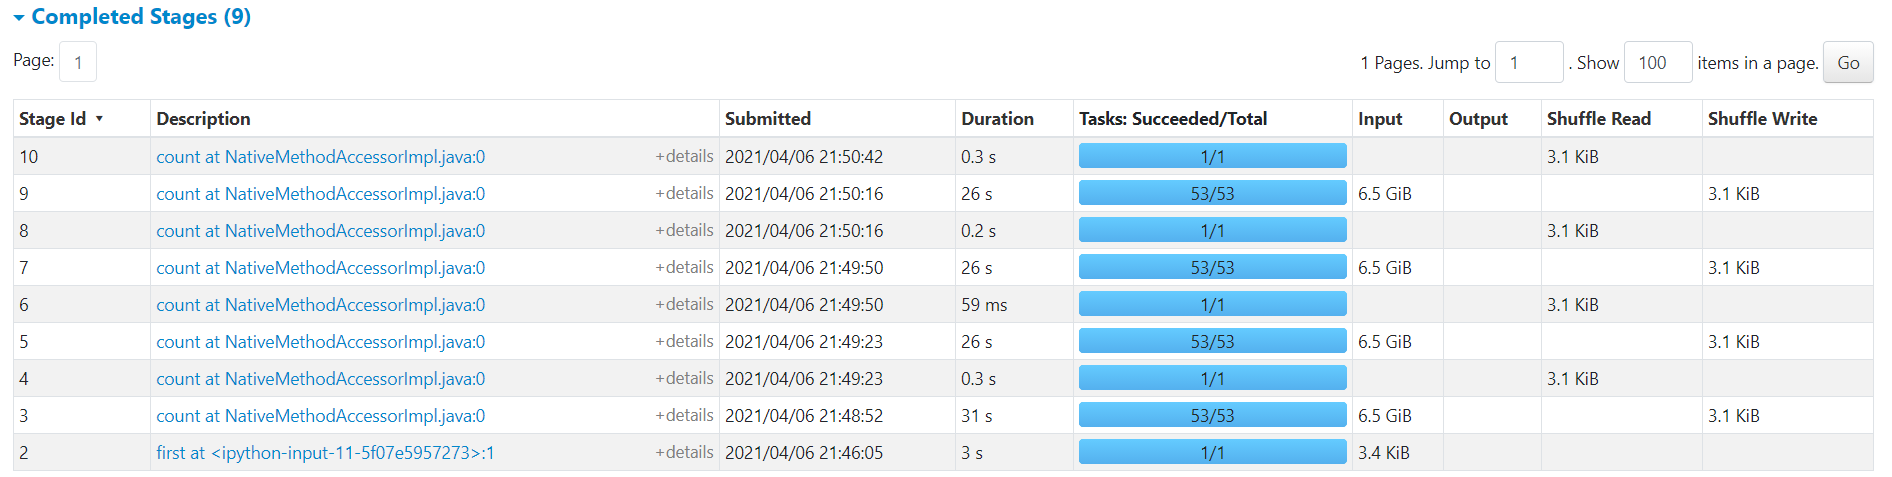

Vous pouvez confirmer que la lecture des 6 Go sur le stockage prend 26 seconde, et ceci à chaque fois qu'on compte le nombre de ligne du dataframe. Il n'y a aucune mise en cache par défaut. Ce sera votre rôle de produire un code efficace en persistant vos données dans Spark à la première utilisation.

In [24]:
sqlDF.cache()

DataFrame[siren: int, nic: int, siret: bigint, dateFin: string, dateDebut: string, etatAdministratifEtablissement: string, changementEtatAdministratifEtablissement: boolean, enseigne1Etablissement: string, enseigne2Etablissement: string, enseigne3Etablissement: string, changementEnseigneEtablissement: boolean, denominationUsuelleEtablissement: string, changementDenominationUsuelleEtablissement: boolean, activitePrincipaleEtablissement: string, nomenclatureActivitePrincipaleEtablissement: string, changementActivitePrincipaleEtablissement: string, caractereEmployeurEtablissement: string, changementCaractereEmployeurEtablissement: string]

l'instruction cache est lazy également... et la persistance (cache) sera faite à la prochaine action global sur le dataframe (comme un count)

In [25]:
%%timeit -r5
sqlDF.count()

362 ms ± 46.8 ms per loop (mean ± std. dev. of 5 runs, 1 loop each)


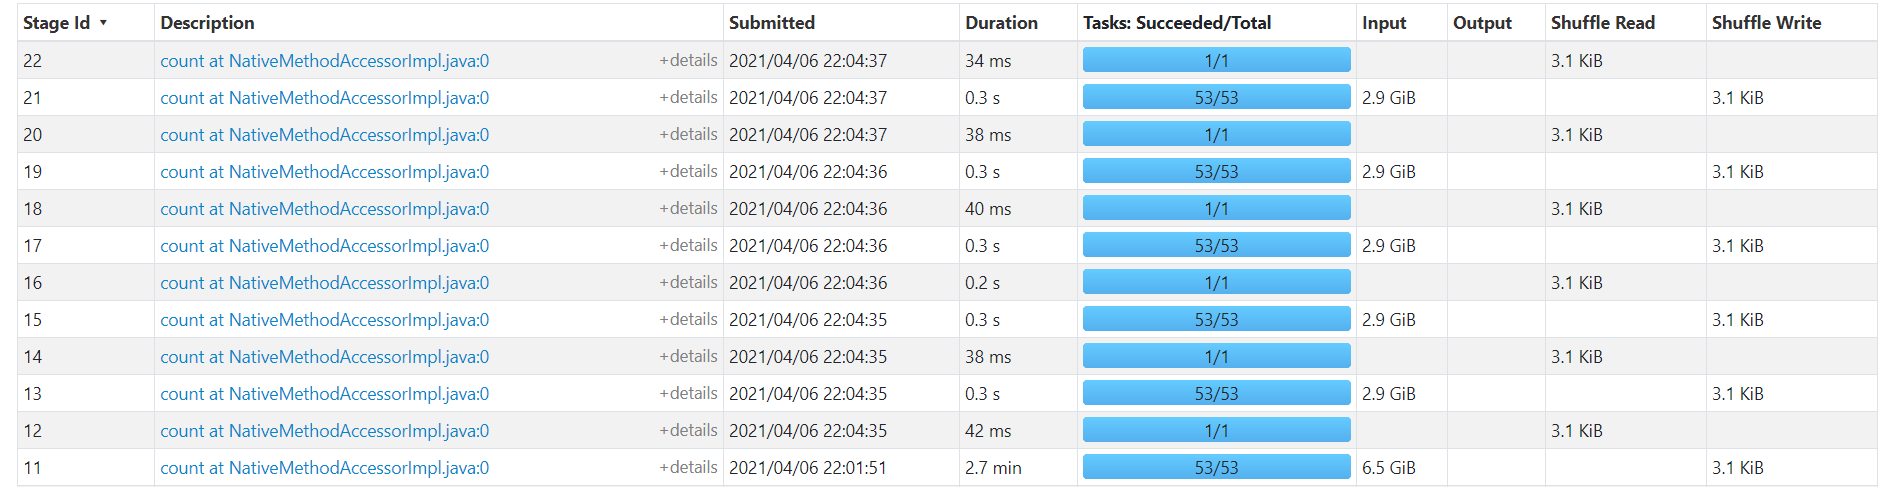

Et vous pouvez vérifier sur votre spark UI : le premier job a été très long, puisque spark avait du travail supplémentaire pour mettre en cache les données (en particulier il doit changer le format des données puisque vous voyez qu'on passe d'un csv de plus de 6go à 2,9go), mais ensuite tous les jobs suivants se sont executés à partir de la donnée en cache, sans jamais revenir à la consultation du fichier sur S3. L'onglet storage vous donne de l'information sur les rdd en cache, le nombre de partitions et si il a pu mettre les données en mémoire ou sur le disque des executeurs.

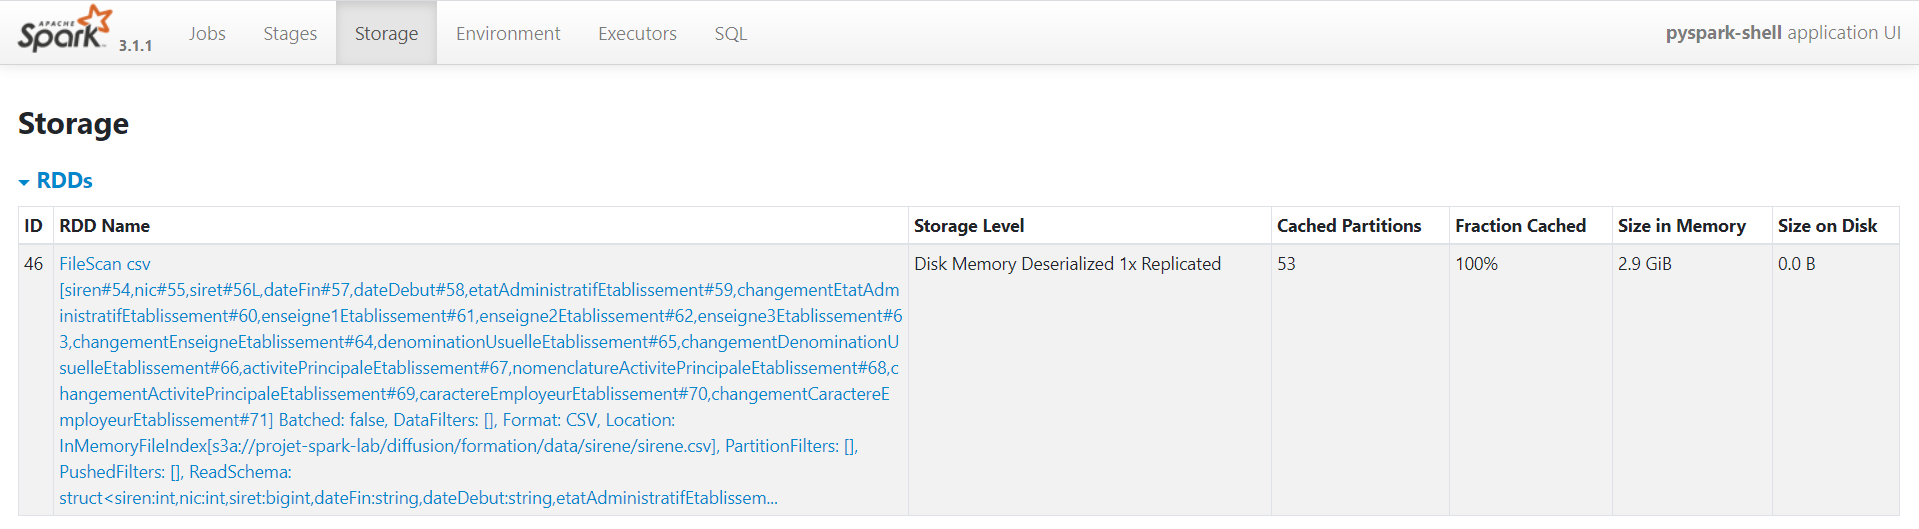

### Un premier group-by pour conclure ce tutorial.

On va grouper par code APE les données en cache sans utiliser la syntaxe SQL.

In [27]:
from pyspark.sql.functions import desc

In [28]:
%%timeit

sqlDF.groupBy("activitePrincipaleEtablissement").count().sort(desc("count")).head(10)

3.12 s ± 163 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Conclusion

Ce tutorial était un peu plus dense en information :
* execution sur un cluster plutot qu'en local mais avec le même code
* appréhender un peu les concepts de transformation, action et de lazy evaluation
* appréhender le cache de donnée

Je vous propose de relacher les ressources consommés par votre spark

In [29]:
spark.stop()

2021-11-04 11:44:26,300 WARN k8s.ExecutorPodsWatchSnapshotSource: Kubernetes client has been closed.
